# 0_read_data

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 35) ## 생략 없이 한 번에 띄울 피쳐수 = 35
import warnings
warnings.filterwarnings('ignore')
from my_func import *

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font",family="Malgun Gothic") ## 폰트       한글 깨짐
plt.rc("axes",unicode_minus=False)    ## 폰트 minus 부호 깨짐
plt.style.use("ggplot")

df1 = pd.read_parquet( "data\df1.parquet" )
df3 = pd.read_parquet( "data\df3.parquet" )

def sp():
    print(f"     {df1.shape[0]:,} x {df1.shape[1]}          {df3.shape[0]:,} x {df3.shape[1]}")
    display(df1.head(1))
    display(df3.head(1))
sp()

     5,623,810 x 23          544,921 x 31


,id,age,man,push,frgn,birth,sign,buy,m_id,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,buy_cut,buy_y,buy_m,buy_d,buy_7,cnt_b
0,357745,58,1,1,0,1963-03-08,2019-08-01 00:35:35.508,2019-08-01 00:32:56.331,9,43000,35000,0,8000,8000,0.0,18.6,18.6,2019-08-01,2019,8,1,3,1


,id,age,man,push,frgn,birth,sign,sign_cut,sign_y,sign_m,sign_d,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,2019,8,25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,0,1,0,0,0,1,0,0,0,0


# 1_2분할

### df3.x: categorical feature

In [2]:
cols = ['id', 'age', 'man', 'push', 'frgn', 'pre', 'post', 'c_back', 'dscnt', 'total', 'cnt_p', 'cnt_b']
df3 = df3[cols]

df3["x"] = df3.pre.apply(lambda x:1 if x>=200000 else 0)  ## df3 구분 피쳐 추가

xmen = set(df3.loc[df3.x==1,"id"])  ## df1 구분 피쳐 추가
df1["x"] = df1.id.apply(lambda x:1 if x in xmen else 0)
sp()

     5,623,810 x 24          544,921 x 13


,id,age,man,push,frgn,birth,sign,buy,m_id,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,buy_cut,buy_y,buy_m,buy_d,buy_7,cnt_b,x
0,357745,58,1,1,0,1963-03-08,2019-08-01 00:35:35.508,2019-08-01 00:32:56.331,9,43000,35000,0,8000,8000,0.0,18.6,18.6,2019-08-01,2019,8,1,3,1,0


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,x
0,1,35,0,0,0,24330,18960,0,5370,5370,1,2,0


In [3]:
data = df3.drop(["id","cnt_p","post"],axis=1).groupby("x").mean()

### 유효숫자 처리
for i in [4,5,6,7]:
    data[data.columns[i]] = data[data.columns[i]].apply(lambda x:round(x))
for i in [0,8]:
    data[data.columns[i]] = data[data.columns[i]].apply(lambda x:round(x,1))
for i in [1,2,3]:
    data[data.columns[i]] = data[data.columns[i]].apply(lambda x:round(100*x,1))
data

,age,man,push,frgn,pre,c_back,dscnt,total,cnt_b
x,,,,,,,,,
0,36.6,37.3,39.7,0.5,58136,278,5838,6115,3.5
1,37.5,31.7,48.3,0.9,656026,4141,40355,44496,30.2


### ----- 보다 자세히

In [4]:
df3_lower, df3_upper, df3_all = df3.loc[df3.x==0], df3.loc[df3.x==1], df3
L,U,N = len(df3_lower), len(df3_upper), len(df3_all)
print(df3_lower.shape, df3_upper.shape, df3_all.shape)

df3["x"] = 1
df3_lower = df3_lower.groupby("x").sum()
df3_upper = df3_upper.groupby("x").sum()
df3_all = df3_all.groupby("x").sum()
data2 = pd.concat([df3_lower,df3_upper,df3_all])
data2 = data2.reset_index(drop=True)
data2["idx"] = ["lower","upper","all"]
data2 = data2.set_index("idx")
data2 = data2.drop(["id","post"],axis=1)
data2

(405502, 13) (139419, 13) (544921, 13)


,age,man,push,frgn,pre,c_back,dscnt,total,cnt_p,cnt_b
idx,,,,,,,,,,
lower,14845778,151295,160819,1897,23574357477,112527762,2367279827,2479807589,405502,1415416
upper,5226231,44144,67302,1244,91462533602,577338309,5626289017,6203627326,139419,4208394
all,20072009,195439,228121,3141,115036891079,689866071,7993568844,8683434915,544921,5623810


In [5]:
data3 = data2.copy()
data3["age"] = round(data2["age"]/data2["cnt_p"],1) #---------- 평균나이
for i in ["man","push","frgn"]: #------------------------------ 남성비율(%), 알람설정비율(%), 외국인비율(%)
    data3[i] = round(100*data2[i]/data2["cnt_p"],1)
for i in ["pre","c_back","dscnt","total","cnt_p","cnt_b"]: #--- 매출액비중(%), 페이백금액비중(%), 할인액비중(%), 혜택비용비중(%), 인원수비중(%), 거래건수비중(%)
    data3[i] = round(100*data2[i]/data2.loc["all",i],1)
for i in ["pre","c_back","dscnt","total"]: #------------------- 1인당 평균 매출액, 1인당 평균 페이백금액, 1인당 평균 할인금액, 1인당 평균 혜택금액
    data3[i+"_1"] = data2[i]//data2["cnt_p"]
data3

,age,man,push,frgn,pre,c_back,dscnt,total,cnt_p,cnt_b,pre_1,c_back_1,dscnt_1,total_1
idx,,,,,,,,,,,,,,
lower,36.6,37.3,39.7,0.5,20.5,16.3,29.6,28.6,74.4,25.2,58136,277,5837,6115
upper,37.5,31.7,48.3,0.9,79.5,83.7,70.4,71.4,25.6,74.8,656026,4141,40355,44496
all,36.8,35.9,41.9,0.6,100.0,100.0,100.0,100.0,100.0,100.0,211107,1265,14669,15935


# 2_시각화

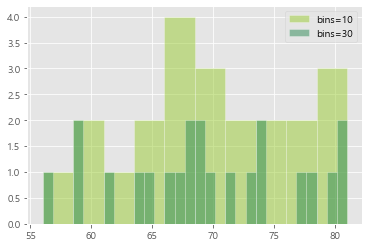

In [6]:
### 샘플
weight = [68, 81, 64, 56, 78, 74, 61, 77, 66, 68, 59, 71,
          80, 59, 67, 81, 69, 73, 69, 74, 70, 65]

plt.hist(weight, bins=10, edgecolor='w', alpha=0.5, label='bins=10', color="yellowgreen", )
plt.hist(weight, bins=30, edgecolor='w', alpha=0.5, label='bins=30', color="seagreen", )
plt.legend()
plt.show()

In [7]:
### 컬럼 순서 조정
data3 = data3[['cnt_p', 'cnt_b', 'age', 'man', 'push', 'frgn', 'pre', 'c_back', 'dscnt', 'total', 'pre_1', 'c_back_1', 'dscnt_1', 'total_1']]
col_title = ["인원 비중","구매횟수 비중","평균 나이","남성 비율(%)","알람설정 비율(%)","외국인 비율(%)","총 매출액 대비 비중(%)","총 캐쉬백금액 대비 비중(%)",
            "총 할인금액 대비 비중(%)","총 혜택금액 대비 비중(%)","1인당 평균 매출액","1인당 평균 페이백금액","1인당 평균 할인금액","1인당 평균 혜택금액"]
data3["pre_tt"] = data2.pre - data2.total
data3["pre_bk"] = data2.c_back
data3["pre_dc"] = data2.dscnt
data3

,cnt_p,cnt_b,age,man,push,frgn,pre,c_back,dscnt,total,pre_1,c_back_1,dscnt_1,total_1,pre_tt,pre_bk,pre_dc
idx,,,,,,,,,,,,,,,,,
lower,74.4,25.2,36.6,37.3,39.7,0.5,20.5,16.3,29.6,28.6,58136,277,5837,6115,21094549888,112527762,2367279827
upper,25.6,74.8,37.5,31.7,48.3,0.9,79.5,83.7,70.4,71.4,656026,4141,40355,44496,85258906276,577338309,5626289017
all,100.0,100.0,36.8,35.9,41.9,0.6,100.0,100.0,100.0,100.0,211107,1265,14669,15935,106353456164,689866071,7993568844


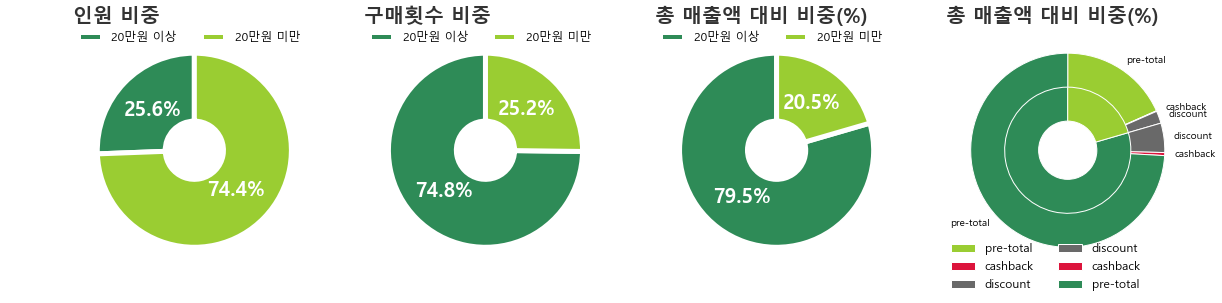

In [8]:
plt.figure(figsize=((20,5)))
x_name, x_color = ['20만원 이상', '20만원 미만'], ['seagreen', 'yellowgreen']
x_wedgeprops = {'width':0.7, 'edgecolor':'w', 'linewidth':5}
x_textprops = {"size":20, "color":"w", "weight":1000, }
for i in [0,1,6]:
    k = 1 if i==0 else k+1
    plt.subplot(1,4,k)
    data = [data3.iloc[1,i], data3.iloc[0,i]]
    plt.pie(data, autopct='%.1f%%', startangle=90, counterclock=True, labels=x_name,
            colors=x_color, wedgeprops=x_wedgeprops, textprops=x_textprops,)
    plt.title(col_title[i], weight=1000, color="k", size=20, alpha=0.8, loc="left", )
    plt.legend(loc=(0,0.92), ncol=2, fontsize=12, frameon=False, shadow=False)

plt.subplot(1,4,4)
i=6
data = [data3.iloc[1,i], data3.iloc[0,i]]
# x_textprops = {"size":15, "color":"k", "weight":1000, }
x_wedgeprops = {'width':0.7, 'edgecolor':'w', 'linewidth':1}
x_name, x_color = ['20만원 이상', '20만원 미만'], ['seagreen', 'yellowgreen']
plt.pie(data, startangle=90, counterclock=True, 
        colors=x_color, wedgeprops=x_wedgeprops, ) # autopct='%.1f%%', 
plt.title(col_title[i], weight=1000, color="k", size=20, alpha=0.8, loc="left", )

i=8
data = [data3.iloc[0,14],data3.iloc[0,15],data3.iloc[0,16],data3.iloc[1,16],data3.iloc[1,15],data3.iloc[1,14]]
x_textprops = {"size":15, "color":"k", "weight":1000, }
x_wedgeprops = {'width':0.35, 'edgecolor':'w', 'linewidth':1}
x_name = ['pre-total','cashback','discount','discount','cashback','pre-total']
x_color = ['yellowgreen','crimson','DimGray','DimGray','crimson','seagreen']
plt.pie(data, startangle=90, counterclock=False, labels=x_name,
        colors=x_color, wedgeprops=x_wedgeprops, ) # textprops=x_textprops, autopct='%.1f%%', 
plt.legend(loc=(0,-0.1), ncol=2, fontsize=12, frameon=False, shadow=False)
plt.show()

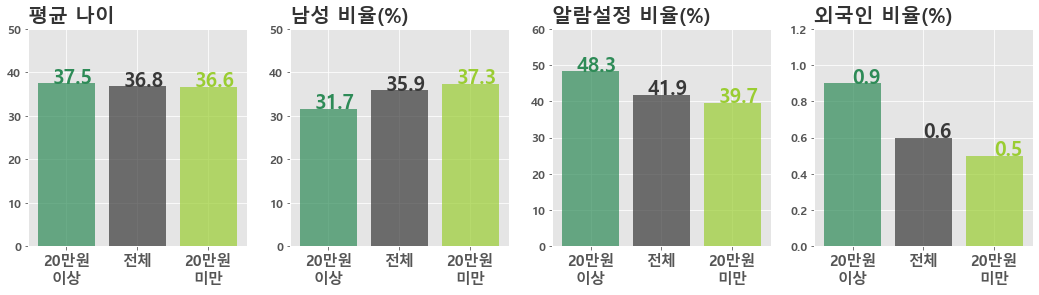

In [9]:
plt.figure(figsize=((18,4)))
x_name, x_color = ['20만원\n이상','전체','20만원\n미만'], ['seagreen','#383838','yellowgreen']
a,b = [0,0,60,60,70,1.4], [0,0,10,10,10,0.2]
for i in [2,3,4,5]:
    k = 1 if i==2 else k+1
    plt.subplot(1,4,k)
    data = [data3.iloc[1,i], data3.iloc[2,i], data3.iloc[0,i]]
    plt.bar( range(3), data, color=x_color, alpha=0.7, )
    for j in range(3):
        c = 0.2 if i==5 else 0
        plt.text( [-0.2+c,0.8+c,1.8+c][j], data[j], data[j], size=20, color=x_color[j], weight=1000, )
    plt.xticks( range(3), x_name, size=15, weight=1000, )
    plt.yticks( np.arange(0,a[i],b[i]), size=12, weight=1000, )
    plt.title(col_title[i], weight=1000, color="k", size=20, alpha=0.8, loc="left", )
plt.show()

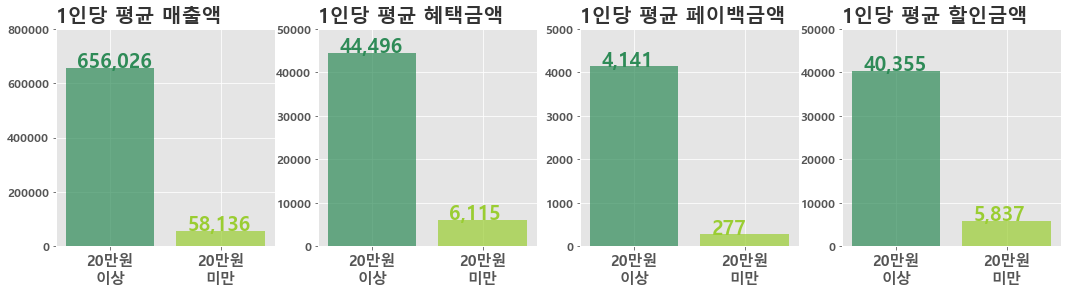

In [10]:
plt.figure(figsize=((18,4)))
x_name, x_color = ['20만원\n이상','20만원\n미만'], ['seagreen','yellowgreen']
a,b = [0]*10+[1000000,6000,60000,60000], [0]*10+[200000,1000,10000,10000]
for i in [10,13,11,12]:
    k = 1 if i==10 else k+1
    plt.subplot(1,4,k)
    data = [data3.iloc[1,i], data3.iloc[0,i]]
    plt.bar( range(2), data, color=x_color, alpha=0.7, )
    for j in range(2):
        plt.text( [-0.3,0.7,1.5][j], data[j], f"{data[j]:,}", size=20, color=x_color[j], weight=1000, )
    plt.xticks( range(2), x_name, size=15, weight=1000, )
    plt.yticks( np.arange(0,a[i],b[i]), size=12, weight=1000, )
    plt.title(col_title[i], weight=1000, color="k", size=20, alpha=0.8, loc="left", )
plt.show()